In [1]:
# importok
from typing import List
import numpy as np

# a colab notebook-ban való futtatáshoz:
!pip install sinter
!pip install pymatching

import sinter
import matplotlib.pyplot as plt
import stim
import sys
import matplotlib as mpl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 51.9 MB/s eta 0:00:00
  Created wheel for sinter: filename=sinter-1.12.0-py3-none-any.whl size=174356 sha256=e958a7ab0c36f3f18b56f0b25e4d6b9c14abb0aa2cb92a1243869f7428593e4a
  Stored in directory: /root/.cache/pip/wheels/4d/43/9f/f32c1922e980232ce8241b8fe0134eb7327a922051ddda3b38
Successfully built sinter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.7/663.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.2 MB/s eta 0:00:00


In [2]:
# Először definiálom a hibamodelleket
def nem_korrelalt_hibamodell(kozpontiX, kozpontiY, x, y, C, p0):
    if x == kozpontiX and y == kozpontiY:
        return p0
    return 0

def exponencialis_p1norma(kozpontiX, kozpontiY, x, y, C, p0):
    d = float(np.abs(kozpontiX - x) + np.abs(kozpontiY - y))
    return p0/C**d

def exponencialis_p2norma(kozpontiX, kozpontiY, x, y, C, p0):
    d = np.sqrt((kozpontiX - x)**2 + (kozpontiY - y)**2)
    return p0/C**d

def polinomialis_p1norma(kozpontiX, kozpontiY, x, y, C, p0):
    if x == kozpontiX and y == kozpontiY:
        return p0
    d = float(np.abs(kozpontiX - x) + np.abs(kozpontiY - y))
    return 0.1*p0/d**C

def polinomialis_p2norma(kozpontiX, kozpontiY, x, y, C, p0):
    if x == kozpontiX and y == kozpontiY:
        return p0
    d = np.sqrt((kozpontiX - x)**2 + (kozpontiY - y)**2)
    return 0.1*p0/d**C

# Utána jönnek a hibamodellek beépítését kezelő függvények

def qubit_hiba(kor: stim.Circuit, dataqubitek: np.ndarray, x: int, y: int, p0: float, hibamodell, C: float):
    """
    Egy (x, y) központú  p0 és C paraméterű hibamodell típusú korrelált hibát helyez el a kor nevezetű kvantumáramkörben.
    """

    # kódtávolság meghatározása
    d = dataqubitek.shape[0]
    # hibaterjedés a központi qubit körül
    valoszinusegtabla = np.array([[hibamodell(x, y, i, j, C, p0) for j in range(d)] for i in range(d)])

    # különböző területen korrelált hibák hozzáadása
    elozohiba = 0
    elso = True
    for hiba in np.unique(valoszinusegtabla):
        # az adott hibához tartozó területen érintett dataqubitek
        resztvevok = dataqubitek[valoszinusegtabla >= hiba]

        # a stim parancs megalkotása
        stim_parancs = f"CORRELATED_ERROR({hiba - elozohiba})" + "".join(f" X{hely}" for hely in resztvevok)
        elozohiba = hiba

        # csak az első nem ELSE_CORRELATED_ERROR
        if not elso:
            stim_parancs = "ELSE_" + stim_parancs
        else:
            elso = False

        # parancs implementálása
        kor.append_from_stim_program_text(stim_parancs)
        # print(stim_parancs)
    return kor

def qubit_hiba_valoszinusegtabla(dataqubitek: np.ndarray, x: int, y: int, p0: float, hibamodell, C: float):
    """
    Meghatározza, hogy a kvantumáramkör mely dataqubitjére mekkora eséllyel terjed tovább az (x, y) központú korrelált hiba.
    """

    # kódtávolság meghatározása
    d = dataqubitek.shape[0]
    # hibaterjedés a központi qubit körül
    return np.array([[hibamodell(x, y, i, j, C, p0) for j in range(d)] for i in range(d)])

def sajat_hiba_berakasa(kor: stim.Circuit, d: int, hibafuggveny, dataqubitek = None):
    """
    A felületi kód kvantumáramkörét módosítja oly módon, hogy a megfelelő helyekre - két stabilizátormérés közé - berakja a hibafuggveny által meghatározott hibamodellt.
    """
    # mivel a stim beépített programjában az utolsó mérés a dataqubitek lemérése, ezzel az egyszerű trükkel kinyerhető a dataqubitek sorszáma, ami egy d*d-s táblázatba rendezve hasznos lehet
    if dataqubitek is None:
        for parancs in kor[::-1]:
            if parancs.name == "M":
                dataqubitek = np.array(parancs.__str__().split()[1:], dtype=int)
                break
        dataqubitek = dataqubitek.reshape(d, d)

    # a végső kör, amibe beleraktuk a hibafüggvényeket:
    eredmeny = stim.Circuit()

    # végigiterálunk a beépített verzión
    H_szamlalo = 0
    for parancs in kor:
        # ha egy blokkról van szó, amit ismételni kell, akkor az rekurzívan szedjük szét
        if isinstance(parancs, stim.CircuitRepeatBlock):
            eredmeny.append(stim.CircuitRepeatBlock(
                repeat_count=parancs.repeat_count,
                body=sajat_hiba_berakasa(parancs.body_copy(), d, hibafuggveny, dataqubitek)
            ))

        # a körök közötti hibát a párátlan sorszámú hadamard kapuk után lehet berakni
        elif parancs.name == "H":
            eredmeny.append(parancs)

            H_szamlalo += 1
            if H_szamlalo%2:
                # hozzáadjuk a saját típusú hibát
                eredmeny = hibafuggveny(eredmeny, dataqubitek)

        # a legtöbb dolgot lemásoljuk
        else:
            eredmeny.append(parancs)
    return eredmeny

def hibafuggveny(p, C, hibamodell):
    """
    A hibamodellt és a paramétereit felhasználva elkészít egy hibafüggvényt, amit a sajat_hiba_berakasa függvény meg tud hívni. Így ennek a függvénynek a visszatérési értéke is egy függvény.
    """
    # elkészítjük a függvényt a paraméterekkel
    def h(kor: stim.Circuit, dataqubitek: np.ndarray):
        d = dataqubitek.shape[0]

        # véigmegyünk az összes dataqubiten, mindegyik központjával csinálunk hibát
        for x in range(d):
            for y in range(d):
                kor = qubit_hiba(kor, dataqubitek, x, y, p, hibamodell, C)

        return kor

    # visszaadjuk az így elkészített függvényt
    return h

def hibafuggveny_javitashoz(p, C, hibamodell, egyszeru = False):
    """
    A hibamodellt és a paramétereit felhasználva elkészít egy egyszerűsített hibafüggvényt, amit a pymatching fel tud használni.
    """
    # elkészítjük a függvényt a paraméterekkel
    def h(kor: stim.Circuit, dataqubitek: np.ndarray):
        d = dataqubitek.shape[0]

        hibaszumma = np.zeros(dataqubitek.shape)

        # véigmegyünk az összes dataqubiten, mindegyik központjával csinálunk hibát, és ennek a valószínűségét a qubitekre szummázzuk
        for x in range(d):
            for y in range(d):
                hibaszumma += qubit_hiba_valoszinusegtabla(dataqubitek, x, y, p, hibamodell, C)

        # végigmegyünk az összes qubiten, és a megfelelő valószínűséggel X hibát rakunk be
        if egyszeru:
            kor.append("X_ERROR", dataqubitek.flat, hibaszumma.mean())
        else:
            for hely, px in zip(dataqubitek.flat, hibaszumma.flat):
                kor.append("X_ERROR", hely, px)

        return kor

    # visszaadjuk az így elkészített függvényt
    return h

def korrelalt_felululeti_kod(d_kodtavolsag, r_korok, p_hiba, C_qubitjosag, hibamodell, egyszerusitett_javitas = False):
    """
    Elkészíti a megadott paramétereknek megfelelő felületi kódot, majd visszatér a sinter által értelmezhető dictionary-vel.
    """

    # a beépített felületi kód
    kor = stim.Circuit.generated(
        code_task="surface_code:rotated_memory_z",
        distance=d_kodtavolsag,
        rounds=r_korok,
        after_clifford_depolarization=p_hiba,
        after_reset_flip_probability=p_hiba,
        before_measure_flip_probability=p_hiba
    )

    # a javításhoz egyszerűsített hibamodell kiszámítása
    javitokor = sajat_hiba_berakasa(kor, d_kodtavolsag, hibafuggveny_javitashoz(p_hiba, C_qubitjosag, hibamodell, egyszerusitett_javitas))

    # korrelált hibák berakása a kódba
    kor =  sajat_hiba_berakasa(kor, d_kodtavolsag, hibafuggveny(p_hiba, C_qubitjosag, hibamodell))

    # összeállítjuk a sinter Task paramétereit
    parameterek = {}
    parameterek["circuit"] = kor
    parameterek["json_metadata"] = {'d': d_kodtavolsag, 'r': r_korok, 'p': p_hiba}
    parameterek["detector_error_model"] = javitokor.detector_error_model(decompose_errors=True)

    return parameterek



In [3]:
# használatra példa

# a korrelációt befolyásoló konstans:
C = 10

vizsgalt_fizikai_hibak = [10**-5, 2*10**-5, 5*10**-5, 5*10**-4, 1*10**-4, 2*10**-4, 5*10**-4, 10**-3, 2*10**-3, 5*10**-3, 8*10**-3, 9*10**-3, 10**-2, 1.1*10**-2, 1.2*10**-2, 1.3*10**-2, 1.5*10**-2, 5*10**-2, 10**-1]
vizsgalt_kodtavolsagok = [3, 5, 7] # jelentősen hosszabb futási idő: [3, 5, 7, 9, 11, 15, 25]

# elkészítjük a vizsgálandó kvantumáramköröket
feluleti_kod_aramkorok = [
    sinter.Task(**korrelalt_felululeti_kod(d, 10, fizikai_hiba, C, exponencialis_p1norma, True))
    for fizikai_hiba in vizsgalt_fizikai_hibak
    for d in vizsgalt_kodtavolsagok
]

# elvégezzük a szimulációt
eredmenyek: List[sinter.TaskStats] = sinter.collect(
    num_workers=2, # a google colab-en két processzor érhető el egyszerre
    tasks=feluleti_kod_aramkorok,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=True,
)

# az eredményekből kivesszük a megjelenítést zavaró elemeket
statisztika = [x for x in eredmenyek if x.errors > 0 and x.errors < x.shots]

Starting 2 workers...
57 cases left:
    pymatching processes=1  ~core_mins_left=None    shots_left=1000000  errors_left=5000    {d=3,p=1e-05,r=10}
    pymatching processes=1  ~core_mins_left=None    shots_left=1000000  errors_left=5000    {d=5,p=1e-05,r=10}
56 cases left:
    pymatching processes=2  ~core_mins_left=1       shots_left=927100   errors_left=5000    {d=5,p=1e-05,r=10}
    pymatching processes=0  ~core_mins_left=5       shots_left=999900   errors_left=5000    {d=7,p=1e-05,r=10}
56 cases left:
    pymatching processes=1  ~core_mins_left=1       shots_left=489700   errors_left=4998    {d=5,p=1e-05,r=10}
    pymatching processes=1  ~core_mins_left=1       shots_left=997300   errors_left=5000    {d=7,p=1e-05,r=10}
55 cases left:
    pymatching processes=2  ~core_mins_left=1       shots_left=927100   errors_left=5000    {d=7,p=1e-05,r=10}
    pymatching processes=0  ~core_mins_left=1       shots_left=999900   errors_left=5000    {d=3,p=2e-05,r=10}
55 cases left:
    pymatching 

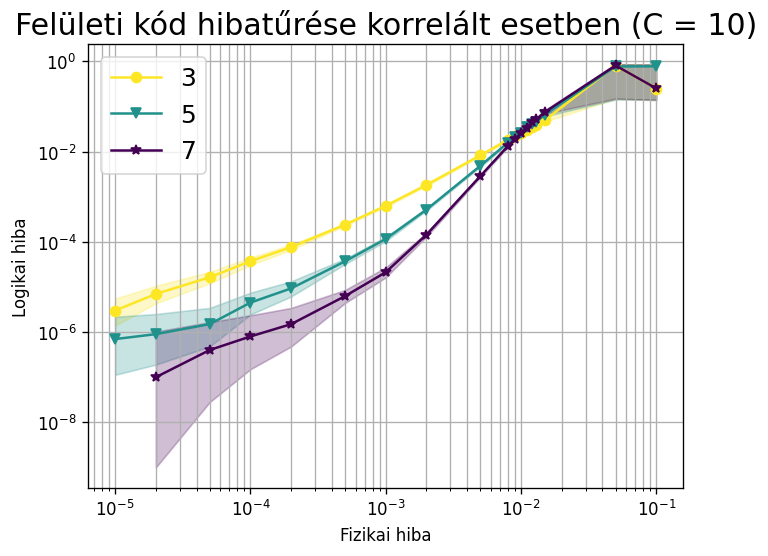

In [4]:
# eredmények rajzolása

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=statisztika,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
    failure_units_per_shot_func=lambda stats: stats.json_metadata['r'],
    plot_args_func=lambda index, d: {'color': mpl.colormaps["viridis"](1 - (d-3)/(max(vizsgalt_kodtavolsagok)-3))}
)

# betűméret beállítása
mpl.rcParams.update({'font.size': 15})

ax.loglog()

ax.set_title(f"Felületi kód hibatűrése korrelált esetben (C = {C})")
ax.set_xlabel("Fizikai hiba")
ax.set_ylabel("Logikai hiba")

ax.grid(which='major')
ax.grid(which='minor')

ax.legend()

fig.set_dpi(120)  # nagyobb legyen a kép

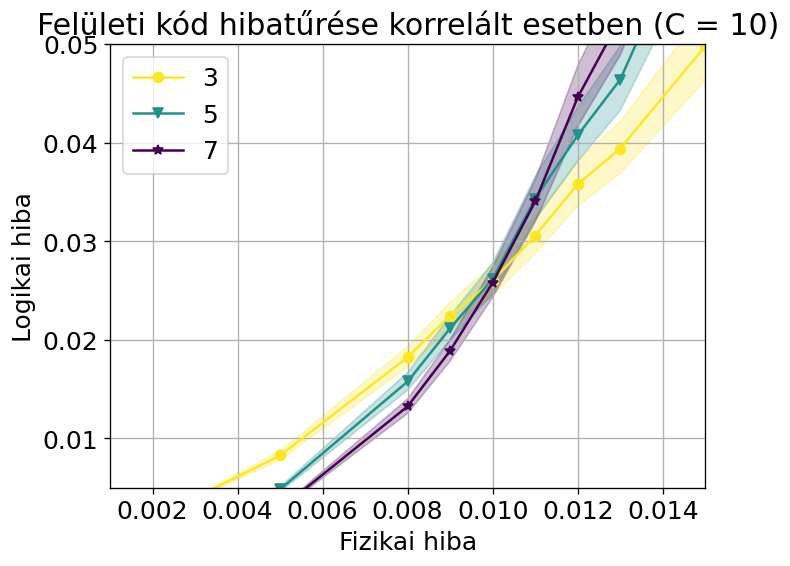

In [5]:
# eredmények rajzolása a hibaküszöb környékén

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=statisztika,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
    failure_units_per_shot_func=lambda stats: stats.json_metadata['r'],
    plot_args_func=lambda index, d: {'color': mpl.colormaps["viridis"](1 - (d-3)/(max(vizsgalt_kodtavolsagok)-3))}
)

# betűméret beállítása
mpl.rcParams.update({'font.size': 15})

ax.set_ylim(5e-3, 5e-2)
ax.set_xlim(0.001, 0.015)

ax.set_title(f"Felületi kód hibatűrése korrelált esetben (C = {C})")
ax.set_xlabel("Fizikai hiba")
ax.set_ylabel("Logikai hiba")

ax.grid(which='major')
ax.grid(which='minor')

ax.legend()

fig.set_dpi(120)  # nagyobb legyen a kép